Importy

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

Wczytywanie danych

In [8]:
print("="*80)
print("WCZYTYWANIE DANYCH")
print("="*80)

# Główne datasety - KODY JAKO STRING!
df_complete = pd.read_csv('./output/complete_dataset.csv', dtype={'powiat_code': str})
df_ml_ready = pd.read_csv('./output/ml_ready_dataset.csv', dtype={'powiat_code': str})
df_2024 = pd.read_csv('./output/complete_dataset_2024.csv', dtype={'powiat_code': str})

# Szczegółowe datasety - KODY JAKO STRING!
df_crime_counts = pd.read_csv('./output/crime/crime_counts_powiaty.csv', dtype={'region_code': str})
df_crime_detection = pd.read_csv('./output/crime/crime_detection_rates_powiaty.csv', dtype={'region_code': str})
df_population = pd.read_csv('./output/population/population_with_density.csv', dtype={'powiat_code': str})
df_unemployment = pd.read_csv('./output/socio/unemployment_powiaty.csv', dtype={'powiat_code': str})
df_wages = pd.read_csv('./output/socio/wages_powiaty.csv', dtype={'powiat_code': str})

print(f"\n✓ Wczytano complete_dataset: {df_complete.shape}")
print(f"✓ Wczytano ml_ready_dataset: {df_ml_ready.shape}")
print(f"✓ Wczytano complete_dataset_2024: {df_2024.shape}")
print(f"✓ Wczytano crime_counts: {df_crime_counts.shape}")
print(f"✓ Wczytano crime_detection: {df_crime_detection.shape}")

WCZYTYWANIE DANYCH

✓ Wczytano complete_dataset: (4752, 29)
✓ Wczytano ml_ready_dataset: (3179, 29)
✓ Wczytano complete_dataset_2024: (396, 29)
✓ Wczytano crime_counts: (38016, 5)
✓ Wczytano crime_detection: (42768, 5)


Statystyki

In [9]:
print("\n" + "="*80)
print("PODSTAWOWE STATYSTYKI - COMPLETE DATASET")
print("="*80)

print("\n--- Informacje o datasecie ---")
print(f"Okres danych: {df_complete['year'].min()} - {df_complete['year'].max()}")
print(f"Liczba powiatów: {df_complete['powiat_code'].nunique()}")
print(f"Liczba lat: {df_complete['year'].nunique()}")
print(f"Całkowita liczba rekordów: {len(df_complete)}")
print(f"Braki danych: {df_complete.isnull().sum().sum()} ({df_complete.isnull().sum().sum() / df_complete.size * 100:.2f}%)")

print("\n--- Statystyki crime_rate_per_100k ---")
print(df_complete['crime_rate_per_100k'].describe())

print("\n--- Top 5 kolumn z brakami danych ---")
missing_cols = df_complete.isnull().sum().sort_values(ascending=False).head()
print(missing_cols[missing_cols > 0])

print("\n--- Rozkład danych po latach ---")
print(df_complete['year'].value_counts().sort_index())


PODSTAWOWE STATYSTYKI - COMPLETE DATASET

--- Informacje o datasecie ---
Okres danych: 2013 - 2024
Liczba powiatów: 396
Liczba lat: 12
Całkowita liczba rekordów: 4752
Braki danych: 11074 (8.04%)

--- Statystyki crime_rate_per_100k ---
count     4560.000000
mean      3292.438044
std       1669.614240
min        851.300000
25%       2323.575000
50%       2972.160000
75%       3839.130000
max      37248.580000
Name: crime_rate_per_100k, dtype: float64

--- Top 5 kolumn z brakami danych ---
wage_category            1142
wage_index               1140
unemployment_rate        1140
unemployment_category    1140
social_risk_score        1140
dtype: int64

--- Rozkład danych po latach ---
year
2013    396
2014    396
2015    396
2016    396
2017    396
2018    396
2019    396
2020    396
2021    396
2022    396
2023    396
2024    396
Name: count, dtype: int64


In [10]:
print("\n" + "="*80)
print("STATYSTYKI ML_READY DATASET (bez braków)")
print("="*80)

print(f"\nLiczba rekordów: {len(df_ml_ready)}")
print(f"Usunięto rekordów z brakami: {len(df_complete) - len(df_ml_ready)}")

print("\n--- Statystyki kluczowych features ---")
key_features = ['crime_rate_per_100k', 'population_density', 'unemployment_rate', 
                'wage_index', 'youth_ratio', 'gender_ratio']
print(df_ml_ready[key_features].describe())


STATYSTYKI ML_READY DATASET (bez braków)

Liczba rekordów: 3179
Usunięto rekordów z brakami: 1573

--- Statystyki kluczowych features ---
       crime_rate_per_100k  population_density  unemployment_rate  \
count          3179.000000         3179.000000        3179.000000   
mean           3121.189566          381.197763           8.671972   
std            1691.390495          666.081555           5.033246   
min             851.300000           17.930000           1.000000   
25%            2226.655000           59.790000           5.000000   
50%            2833.680000           97.290000           7.500000   
75%            3595.080000          212.580000          11.300000   
max           37248.580000         3961.080000          34.400000   

        wage_index  youth_ratio  gender_ratio  
count  3179.000000  3179.000000   3179.000000  
mean     86.139509     0.173687     95.578795  
std      10.900648     0.022549      3.455629  
min       0.000000     0.115200     83.500000  

Trendy czasowe

In [11]:
print("\n" + "="*80)
print("TRENDY CZASOWE - PRZESTĘPCZOŚĆ W POLSCE")
print("="*80)

# Agregacja danych rocznych dla całej Polski
yearly_stats = df_complete.groupby('year').agg({
    'crime_rate_per_100k': 'mean',
    'total_crimes': 'sum',
    'total_population': 'sum',
    'unemployment_rate': 'mean',
    'wage_index': 'mean'
}).reset_index()

print("\n--- Średni wskaźnik przestępczości w Polsce (rok po roku) ---")
print(yearly_stats[['year', 'crime_rate_per_100k', 'total_crimes']])

# Obliczenie zmian rok do roku
yearly_stats['crime_change_pct'] = yearly_stats['crime_rate_per_100k'].pct_change() * 100
yearly_stats['unemployment_change_pct'] = yearly_stats['unemployment_rate'].pct_change() * 100

print("\n--- Procentowe zmiany rok do roku ---")
print(yearly_stats[['year', 'crime_change_pct', 'unemployment_change_pct']].dropna())


TRENDY CZASOWE - PRZESTĘPCZOŚĆ W POLSCE

--- Średni wskaźnik przestępczości w Polsce (rok po roku) ---
    year  crime_rate_per_100k  total_crimes
0   2013          4332.268368     3680852.0
1   2014          3436.289921     2970496.0
2   2015          3181.244132     2724804.0
3   2016          2956.643579     2528936.0
4   2017          2957.256947     2512130.0
5   2018          3096.006895     2595094.0
6   2019          3188.265447     2709252.0
7   2020          3218.004316     2570476.0
8   2021          3360.656658     2771642.0
9   2022          3495.150868     2850072.0
10  2023          3210.198421     2646452.0
11  2024          3077.270974     2483968.0

--- Procentowe zmiany rok do roku ---
    year  crime_change_pct  unemployment_change_pct
1   2014        -20.681508               -14.124153
2   2015         -7.422127               -13.089474
3   2016         -7.060148               -14.562268
4   2017          0.020745               -18.524435
5   2018          4.69184

Wykres trendy polski

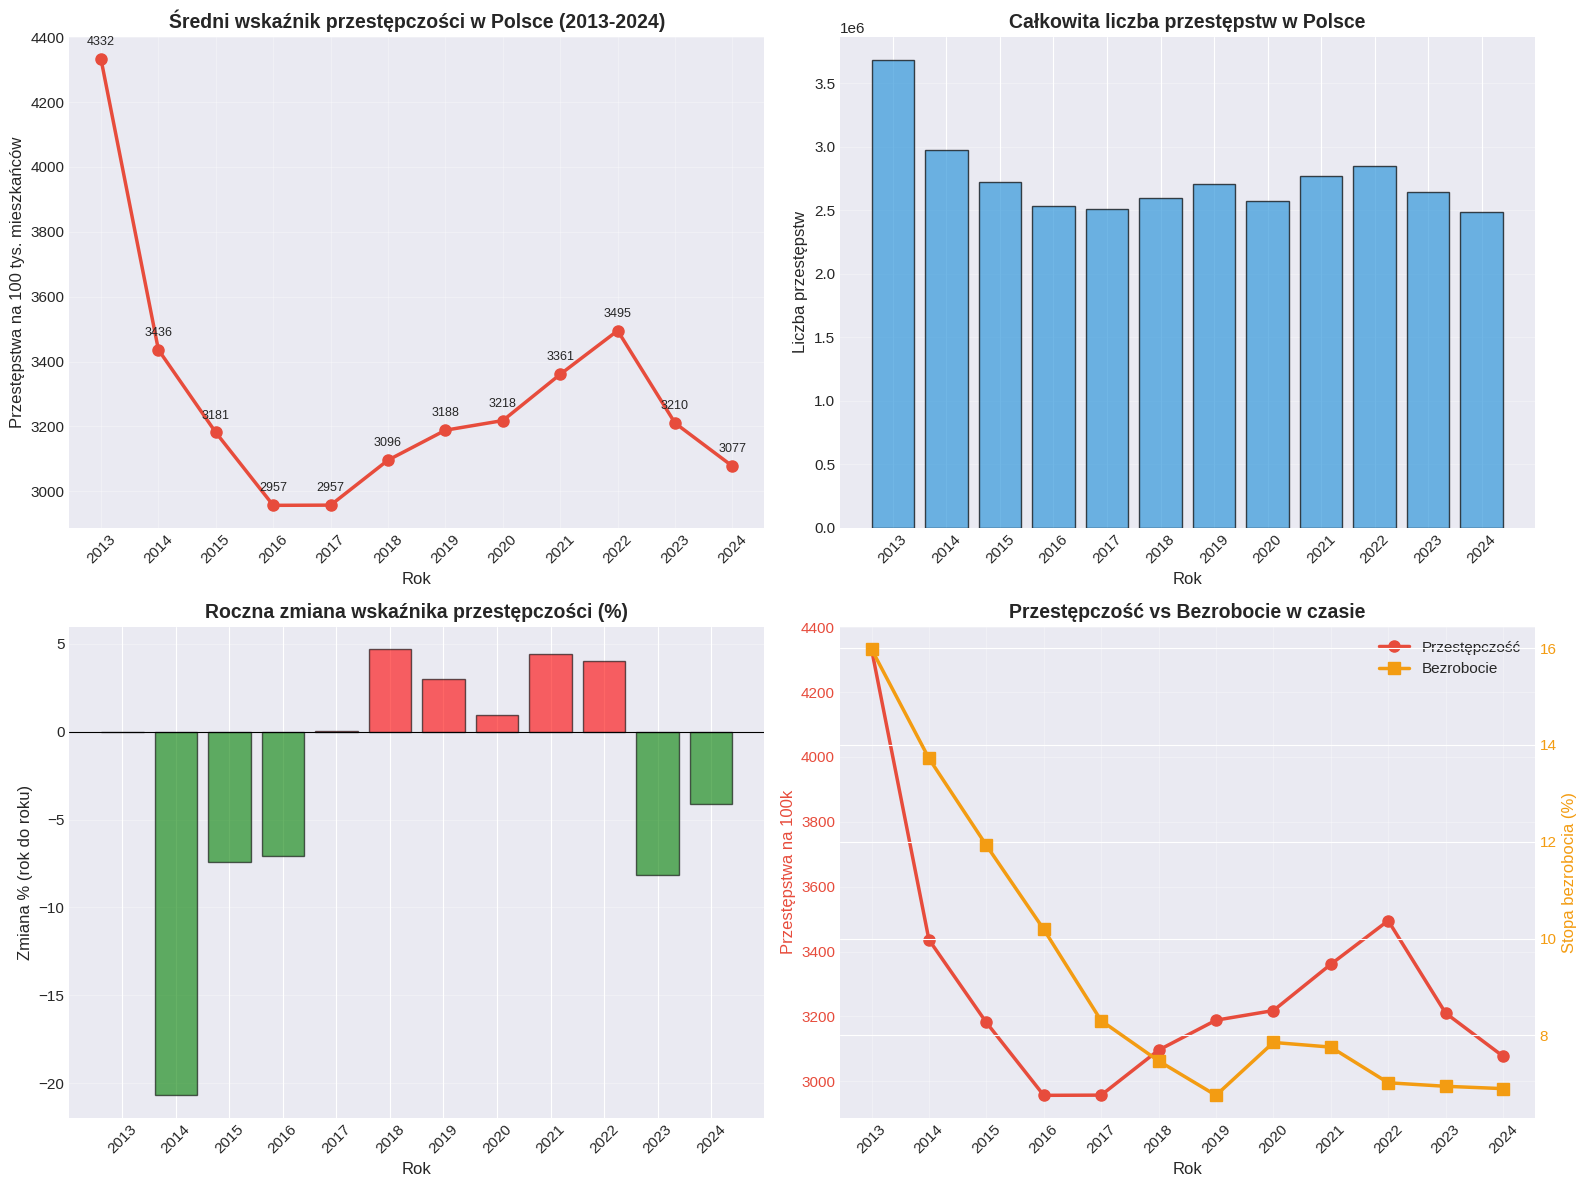


✓ Wykres zapisany jako 'trendy_czasowe_polska.png'


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Wykres 1: Średni wskaźnik przestępczości w Polsce
ax1 = axes[0, 0]
ax1.plot(yearly_stats['year'], yearly_stats['crime_rate_per_100k'], 
         marker='o', linewidth=2.5, markersize=8, color='#e74c3c')
ax1.set_title('Średni wskaźnik przestępczości w Polsce (2013-2024)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Rok', fontsize=12)
ax1.set_ylabel('Przestępstwa na 100 tys. mieszkańców', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(yearly_stats['year'])
ax1.set_xticklabels(yearly_stats['year'], rotation=45)

# Dodanie wartości na wykresie
for x, y in zip(yearly_stats['year'], yearly_stats['crime_rate_per_100k']):
    ax1.annotate(f'{y:.0f}', (x, y), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)

# Wykres 2: Całkowita liczba przestępstw
ax2 = axes[0, 1]
ax2.bar(yearly_stats['year'], yearly_stats['total_crimes'], 
        color='#3498db', alpha=0.7, edgecolor='black')
ax2.set_title('Całkowita liczba przestępstw w Polsce', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Rok', fontsize=12)
ax2.set_ylabel('Liczba przestępstw', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(yearly_stats['year'])
ax2.set_xticklabels(yearly_stats['year'], rotation=45)

# Wykres 3: Procentowa zmiana rok do roku
ax3 = axes[1, 0]
colors = ['green' if x < 0 else 'red' for x in yearly_stats['crime_change_pct'].fillna(0)]
ax3.bar(yearly_stats['year'], yearly_stats['crime_change_pct'].fillna(0), 
        color=colors, alpha=0.6, edgecolor='black')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax3.set_title('Roczna zmiana wskaźnika przestępczości (%)', 
              fontsize=14, fontweight='bold')
ax3.set_xlabel('Rok', fontsize=12)
ax3.set_ylabel('Zmiana % (rok do roku)', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_xticks(yearly_stats['year'])
ax3.set_xticklabels(yearly_stats['year'], rotation=45)

# Wykres 4: Przestępczość vs Bezrobocie
ax4 = axes[1, 1]
ax4_twin = ax4.twinx()

line1 = ax4.plot(yearly_stats['year'], yearly_stats['crime_rate_per_100k'], 
                 marker='o', linewidth=2.5, markersize=8, color='#e74c3c', label='Przestępczość')
line2 = ax4_twin.plot(yearly_stats['year'], yearly_stats['unemployment_rate'], 
                      marker='s', linewidth=2.5, markersize=8, color='#f39c12', label='Bezrobocie')

ax4.set_title('Przestępczość vs Bezrobocie w czasie', 
              fontsize=14, fontweight='bold')
ax4.set_xlabel('Rok', fontsize=12)
ax4.set_ylabel('Przestępstwa na 100k', fontsize=12, color='#e74c3c')
ax4_twin.set_ylabel('Stopa bezrobocia (%)', fontsize=12, color='#f39c12')
ax4.tick_params(axis='y', labelcolor='#e74c3c')
ax4_twin.tick_params(axis='y', labelcolor='#f39c12')
ax4.grid(True, alpha=0.3)
ax4.set_xticks(yearly_stats['year'])
ax4.set_xticklabels(yearly_stats['year'], rotation=45)

# Legenda
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax4.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.savefig('./output/imgs/trendy_czasowe_polska.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Wykres zapisany jako 'trendy_czasowe_polska.png'")

TOP 5 najniebezpieczniejszych / najbezpieczniejszych

In [13]:
print("\n" + "="*80)
print("TRENDY PO WOJEWÓDZTWACH")
print("="*80)

# Ekstrakcja województwa z nazwy powiatu (pierwsze 2 znaki kodu TERYT)
df_complete["wojewodztwo_code"] = df_complete["powiat_code"].astype(str).str.zfill(7).str[:2]

# Mapowanie kodów województw na nazwy
wojewodztwa_map = {
    '02': 'dolnośląskie', '04': 'kujawsko-pomorskie', '06': 'lubelskie',
    '08': 'lubuskie', '10': 'łódzkie', '12': 'małopolskie',
    '14': 'mazowieckie', '16': 'opolskie', '18': 'podkarpackie',
    '20': 'podlaskie', '22': 'pomorskie', '24': 'śląskie',
    '26': 'świętokrzyskie', '28': 'warmińsko-mazurskie', '30': 'wielkopolskie',
    '32': 'zachodniopomorskie'
}

df_complete['wojewodztwo'] = df_complete['wojewodztwo_code'].map(wojewodztwa_map)

# Filtruj tylko powiaty (wykluczamy województwa które kończą się na 00000)
df_only_powiaty = df_complete[df_complete['powiat_code'].astype(str).str.endswith('00000') == False].copy()

# Grupuj i oblicz wskaźnik przestępczości
wojewodztwa_yearly = df_only_powiaty.groupby(['wojewodztwo', 'year']).apply(
    lambda x: pd.Series({
        'crime_rate_per_100k': (x['total_crimes'].sum() / x['total_population'].sum() * 100000)
    }), include_groups=False
).reset_index()

# Filtruj 2024
wojewodztwa_2024 = wojewodztwa_yearly[wojewodztwa_yearly['year'] == 2024].sort_values(
    'crime_rate_per_100k', ascending=False
)

print("\n--- TOP 5 Województw z najwyższą przestępczością (2024) ---")
print(wojewodztwa_2024.head().to_string(index=False))

print("\n--- TOP 5 Województw z najniższą przestępczością (2024) ---")
print(wojewodztwa_2024.tail().to_string(index=False))

print("\n--- Wszystkie wojewodztwa ---")
print(wojewodztwa_2024)


TRENDY PO WOJEWÓDZTWACH

--- TOP 5 Województw z najwyższą przestępczością (2024) ---
 wojewodztwo  year  crime_rate_per_100k
dolnośląskie  2024          4309.538735
    lubuskie  2024          3982.805039
     śląskie  2024          3833.304477
   pomorskie  2024          3685.198473
 mazowieckie  2024          3557.635156

--- TOP 5 Województw z najniższą przestępczością (2024) ---
   wojewodztwo  year  crime_rate_per_100k
      opolskie  2024          2807.493529
świętokrzyskie  2024          2541.211460
     lubelskie  2024          2540.171505
     podlaskie  2024          2418.859992
  podkarpackie  2024          1995.349484

--- Wszystkie wojewodztwa ---
             wojewodztwo  year  crime_rate_per_100k
11          dolnośląskie  2024          4309.538735
47              lubuskie  2024          3982.805039
179              śląskie  2024          3833.304477
119            pomorskie  2024          3685.198473
59           mazowieckie  2024          3557.635156
71           małop

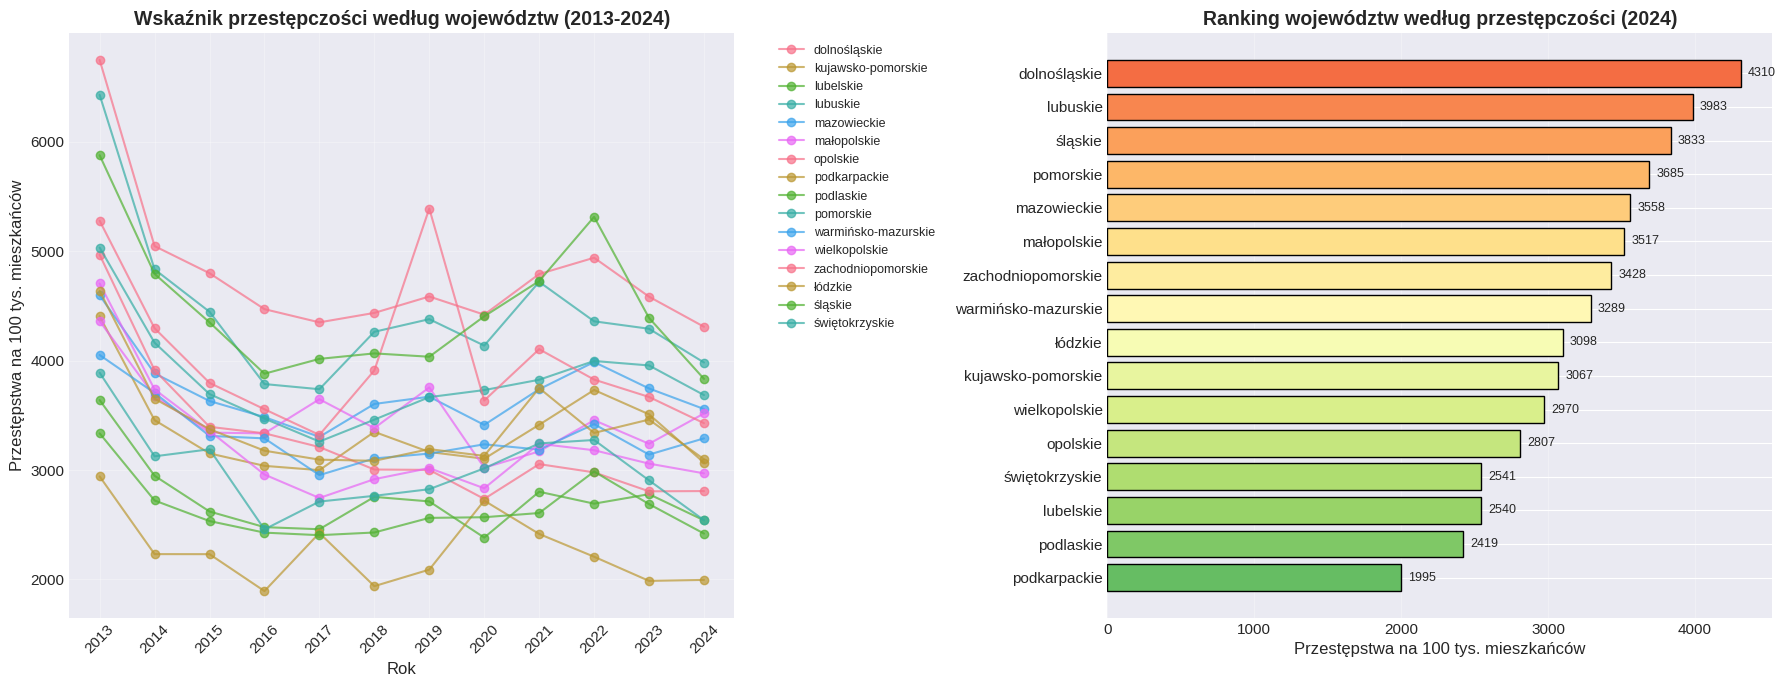


✓ Wykres zapisany jako 'trendy_wojewodztwa.png'


In [14]:
# Wykres liniowy - wszystkie województwa
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

ax1 = axes[0]
for woj in wojewodztwa_yearly['wojewodztwo'].unique():
    if pd.notna(woj):
        woj_data = wojewodztwa_yearly[wojewodztwa_yearly['wojewodztwo'] == woj]
        ax1.plot(woj_data['year'], woj_data['crime_rate_per_100k'], 
                marker='o', linewidth=1.5, label=woj, alpha=0.7)

ax1.set_title('Wskaźnik przestępczości według województw (2013-2024)', 
             fontsize=14, fontweight='bold')
ax1.set_xlabel('Rok', fontsize=12)
ax1.set_ylabel('Przestępstwa na 100 tys. mieszkańców', fontsize=12)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(wojewodztwa_yearly['year'].unique())
ax1.set_xticklabels(wojewodztwa_yearly['year'].unique(), rotation=45)

# Wykres słupkowy - ranking 2024
ax2 = axes[1]
wojewodztwa_2024_sorted = wojewodztwa_2024.sort_values('crime_rate_per_100k')
colors_woj = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(wojewodztwa_2024_sorted)))

ax2.barh(wojewodztwa_2024_sorted['wojewodztwo'], 
        wojewodztwa_2024_sorted['crime_rate_per_100k'],
        color=colors_woj, edgecolor='black')
ax2.set_title('Ranking województw według przestępczości (2024)', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('Przestępstwa na 100 tys. mieszkańców', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')

# Dodanie wartości na wykresie
for i, (woj, val) in enumerate(zip(wojewodztwa_2024_sorted['wojewodztwo'], 
                                    wojewodztwa_2024_sorted['crime_rate_per_100k'])):
    ax2.text(val + 50, i, f'{val:.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('./output/imgs/trendy_wojewodztwa.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Wykres zapisany jako 'trendy_wojewodztwa.png'")

In [15]:
print("\n" + "="*80)
print("PODSUMOWANIE ANALIZY TRENDÓW CZASOWYCH")
print("="*80)

# Ogólny trend
first_year = yearly_stats.iloc[0]
last_year = yearly_stats.iloc[-1]
total_change = ((last_year['crime_rate_per_100k'] - first_year['crime_rate_per_100k']) / 
                first_year['crime_rate_per_100k'] * 100)

print(f"\n📊 POLSKA OGÓŁEM:")
print(f"   Wskaźnik przestępczości {int(first_year['year'])}: {first_year['crime_rate_per_100k']:.0f}")
print(f"   Wskaźnik przestępczości {int(last_year['year'])}: {last_year['crime_rate_per_100k']:.0f}")
print(f"   Zmiana całkowita: {total_change:+.1f}%")

# Rok z najwyższą i najniższą przestępczością
max_crime_year = yearly_stats.loc[yearly_stats['crime_rate_per_100k'].idxmax()]
min_crime_year = yearly_stats.loc[yearly_stats['crime_rate_per_100k'].idxmin()]

print(f"\n   Rok z najwyższą przestępczością: {int(max_crime_year['year'])} ({max_crime_year['crime_rate_per_100k']:.0f})")
print(f"   Rok z najniższą przestępczością: {int(min_crime_year['year'])} ({min_crime_year['crime_rate_per_100k']:.0f})")

# Trend bezrobocia
unemployment_change = ((last_year['unemployment_rate'] - first_year['unemployment_rate']) / 
                      first_year['unemployment_rate'] * 100)
print(f"\n📉 BEZROBOCIE:")
print(f"   Stopa bezrobocia {int(first_year['year'])}: {first_year['unemployment_rate']:.1f}%")
print(f"   Stopa bezrobocia {int(last_year['year'])}: {last_year['unemployment_rate']:.1f}%")
print(f"   Zmiana: {unemployment_change:+.1f}%")

print("\n" + "="*80)
print("CZĘŚĆ 1 ZAKOŃCZONA - Trendy czasowe")
print("="*80)


PODSUMOWANIE ANALIZY TRENDÓW CZASOWYCH

📊 POLSKA OGÓŁEM:
   Wskaźnik przestępczości 2013: 4332
   Wskaźnik przestępczości 2024: 3077
   Zmiana całkowita: -29.0%

   Rok z najwyższą przestępczością: 2013 (4332)
   Rok z najniższą przestępczością: 2016 (2957)

📉 BEZROBOCIE:
   Stopa bezrobocia 2013: 16.0%
   Stopa bezrobocia 2024: 6.9%
   Zmiana: -56.8%

CZĘŚĆ 1 ZAKOŃCZONA - Trendy czasowe


In [16]:
# Target variable
target = 'crime_rate_per_100k'

# Features do analizy
features_numeric = [
    'population_density',          # Gęstość zaludnienia
    'unemployment_rate',           # Bezrobocie
    'wage_index',                  # Wynagrodzenia
    'youth_ratio',                 # Udział młodzieży 15-29
    'middle_age_ratio',            # Udział 30-49 lat
    'elderly_ratio',               # Udział 50-69 lat
    'gender_ratio',                # Mężczyźni na 100 kobiet
    'population_change_pct',       # Zmiana populacji r/r
    'total_population'             # Całkowita populacja
]

# Tworzenie DataFrame tylko z wybranymi kolumnami
df_corr = df_ml_ready[[target] + features_numeric].copy()

print("\n--- Zmienne do analizy korelacji ---")
for i, col in enumerate([target] + features_numeric, 1):
    print(f"{i}. {col}")


--- Zmienne do analizy korelacji ---
1. crime_rate_per_100k
2. population_density
3. unemployment_rate
4. wage_index
5. youth_ratio
6. middle_age_ratio
7. elderly_ratio
8. gender_ratio
9. population_change_pct
10. total_population


In [17]:
print("\n" + "="*80)
print("MACIERZ KORELACJI")
print("="*80)

# Obliczenie macierzy korelacji Pearsona
correlation_matrix = df_corr.corr()

# Korelacje z crime_rate_per_100k
correlations_with_target = correlation_matrix[target].sort_values(ascending=False)

print("\n--- Korelacje z wskaźnikiem przestępczości ---")
print(correlations_with_target)

# Najsilniejsze korelacje (absolutne wartości)
print("\n--- TOP 5 najsilniejszych korelacji (|r|) ---")
abs_correlations = correlations_with_target.abs().sort_values(ascending=False)
print(abs_correlations.head(6)[1:])  # Pomijamy samą zmienną target


MACIERZ KORELACJI

--- Korelacje z wskaźnikiem przestępczości ---
crime_rate_per_100k      1.000000
population_density       0.420302
wage_index               0.269575
elderly_ratio            0.199952
middle_age_ratio         0.175291
total_population         0.150777
population_change_pct   -0.074883
unemployment_rate       -0.154331
youth_ratio             -0.290256
gender_ratio            -0.423999
Name: crime_rate_per_100k, dtype: float64

--- TOP 5 najsilniejszych korelacji (|r|) ---
gender_ratio          0.423999
population_density    0.420302
youth_ratio           0.290256
wage_index            0.269575
elderly_ratio         0.199952
Name: crime_rate_per_100k, dtype: float64


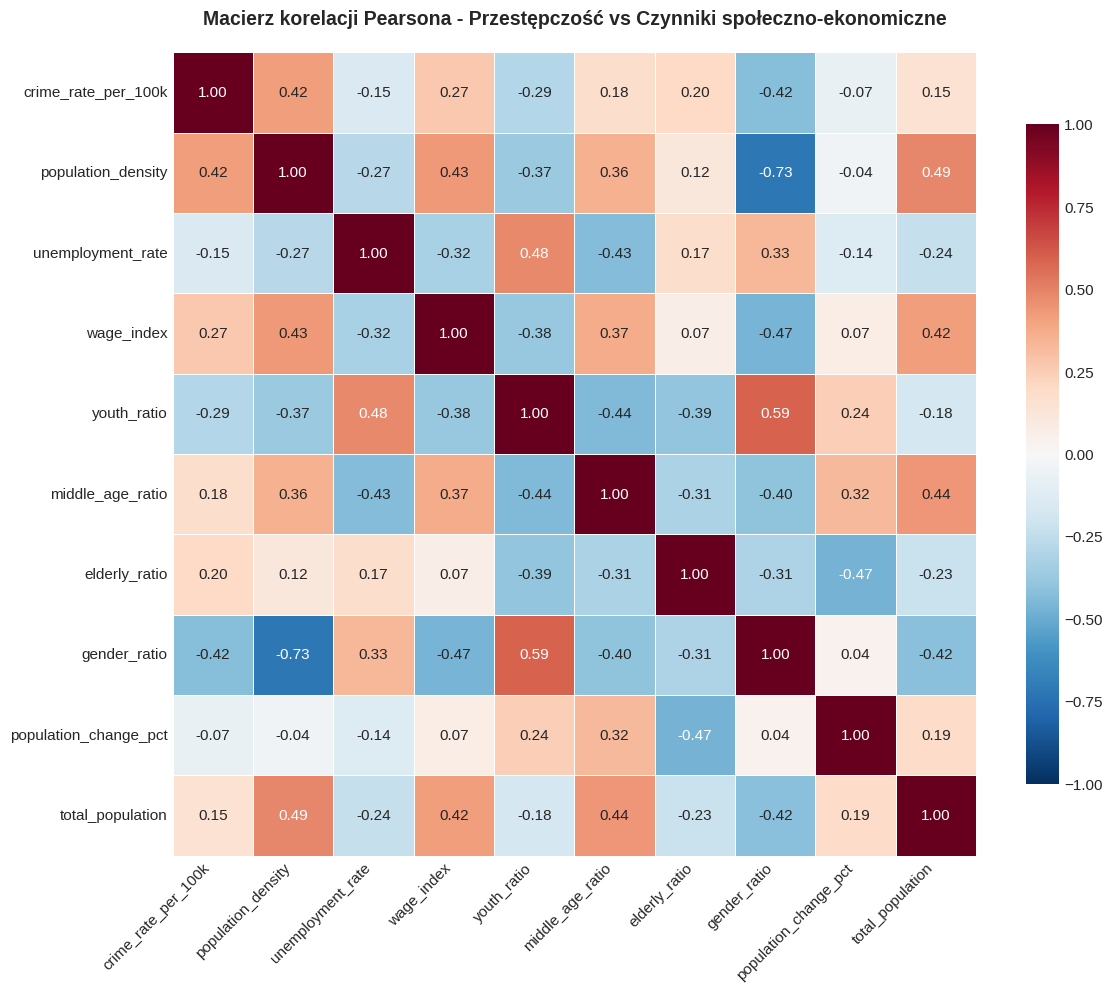


✓ Heatmapa zapisana jako 'korelacje_heatmapa.png'


In [18]:
fig, ax = plt.subplots(figsize=(12, 10))

# Tworzenie heatmapy
sns.heatmap(correlation_matrix, 
            annot=True,           # Pokazuj wartości
            fmt='.2f',            # Format liczb
            cmap='RdBu_r',        # Kolory: czerwony (dodatnia) - biały - niebieski (ujemna)
            center=0,             # Środek skali na 0
            square=True,          # Kwadratowe komórki
            linewidths=0.5,       # Linie między komórkami
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1,      # Zakres od -1 do 1
            ax=ax)

ax.set_title('Macierz korelacji Pearsona - Przestępczość vs Czynniki społeczno-ekonomiczne', 
             fontsize=14, fontweight='bold', pad=20)

# Rotacja etykiet
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('./output/imgs/korelacje_heatmapa.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Heatmapa zapisana jako 'korelacje_heatmapa.png'")


SCATTER PLOTS - WIZUALIZACJA ZALEŻNOŚCI


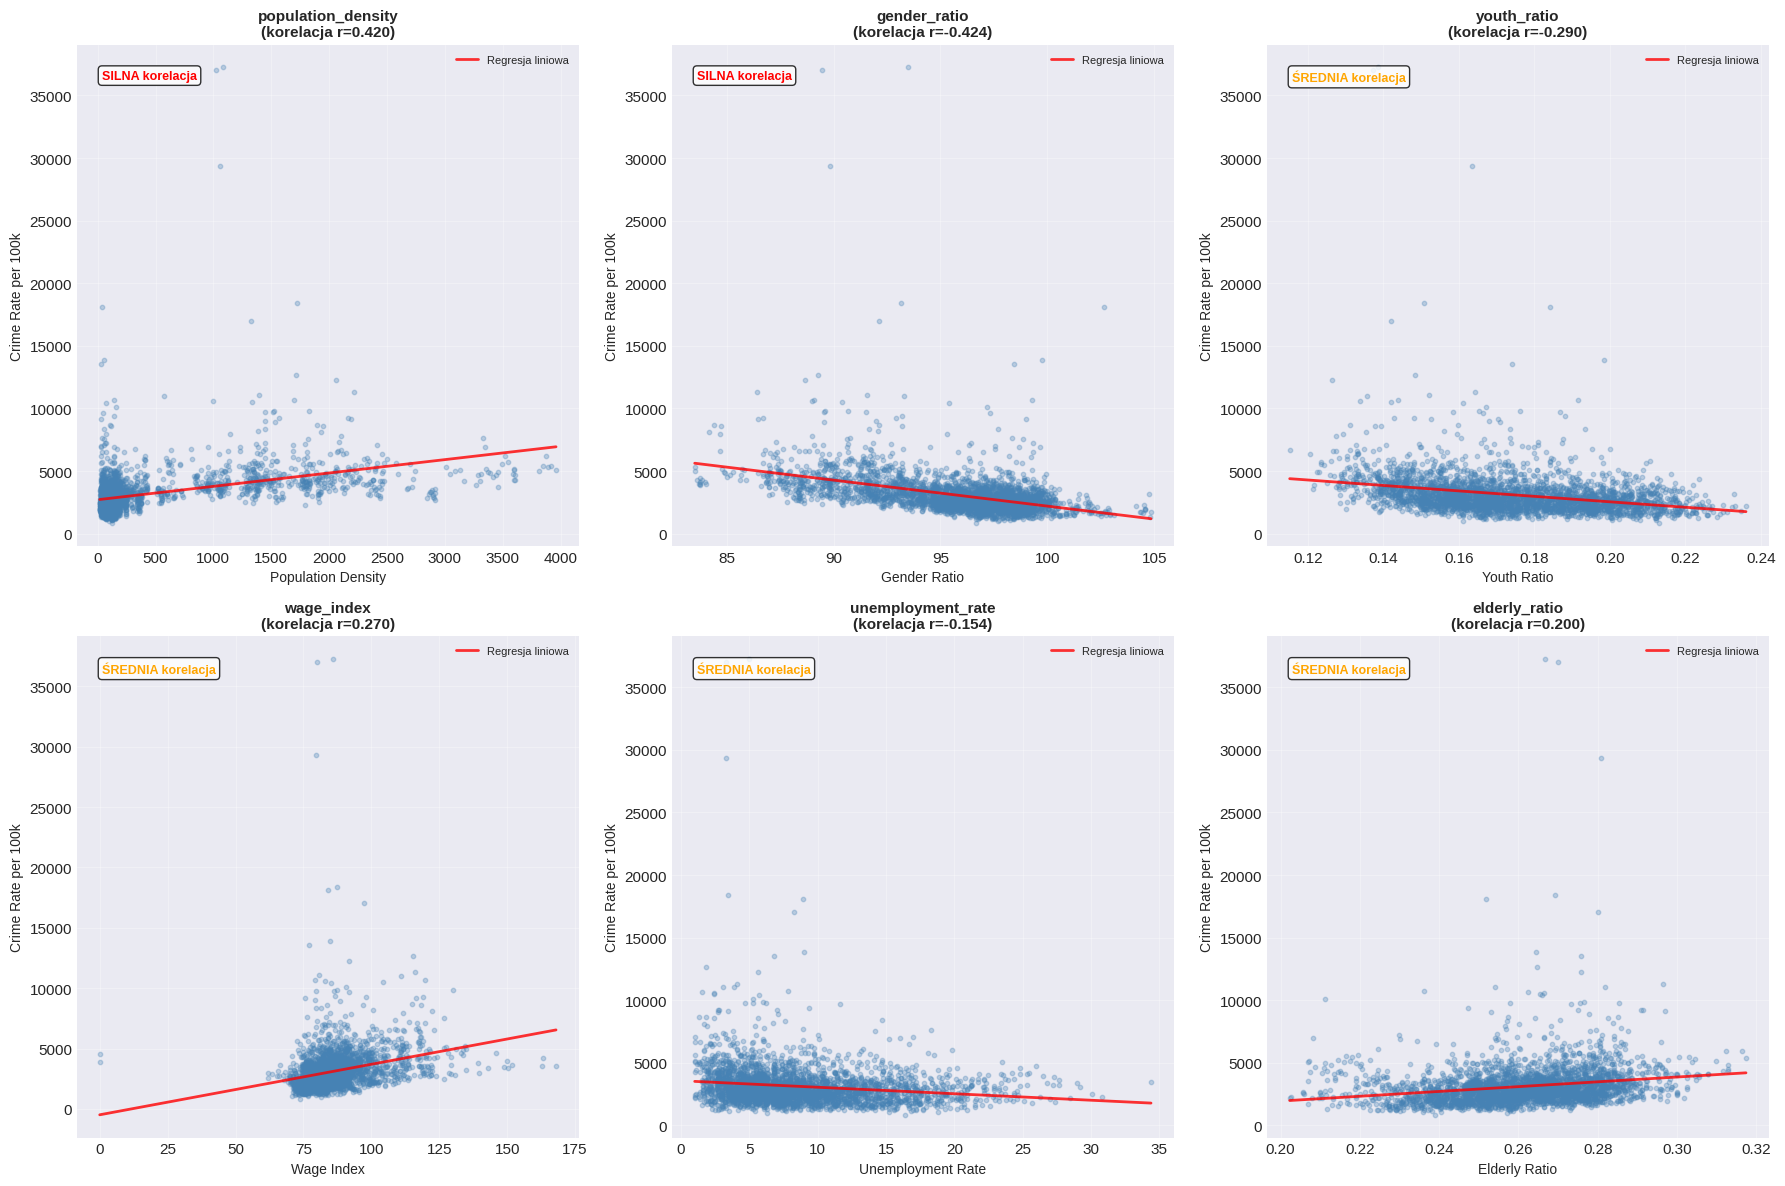


✓ Scatter plots zapisane jako 'korelacje_scatter_plots.png'


In [19]:
print("\n" + "="*80)
print("SCATTER PLOTS - WIZUALIZACJA ZALEŻNOŚCI")
print("="*80)

# Wybieramy 6 najważniejszych features do wizualizacji
top_features = [
    'population_density',
    'gender_ratio',
    'youth_ratio',
    'wage_index',
    'unemployment_rate',
    'elderly_ratio'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(df_ml_ready[feature], df_ml_ready[target], alpha=0.3, s=10, color='steelblue')
    
    # Linia regresji
    z = np.polyfit(df_ml_ready[feature].dropna(), df_ml_ready[df_ml_ready[feature].notna()][target], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_ml_ready[feature].min(), df_ml_ready[feature].max(), 100)
    ax.plot(x_line, p(x_line), "r-", linewidth=2, alpha=0.8, label='Regresja liniowa')
    
    # Korelacja
    corr = correlation_matrix.loc[target, feature]
    
    # Tytuł i etykiety
    ax.set_title(f'{feature}\n(korelacja r={corr:.3f})', 
                fontsize=11, fontweight='bold')
    ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=10)
    ax.set_ylabel('Crime Rate per 100k', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # Dodanie tekstu z interpretacją
    if abs(corr) > 0.3:
        strength = "SILNA"
        color = 'red'
    elif abs(corr) > 0.15:
        strength = "ŚREDNIA"
        color = 'orange'
    else:
        strength = "SŁABA"
        color = 'gray'
    
    ax.text(0.05, 0.95, f'{strength} korelacja', 
           transform=ax.transAxes, fontsize=9, 
           verticalalignment='top', color=color, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('./output/imgs/korelacje_scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Scatter plots zapisane jako 'korelacje_scatter_plots.png'")

In [20]:
print("\n" + "="*80)
print("ANALIZA PARADOKSÓW I NIEINTUICYJNYCH ZALEŻNOŚCI")
print("="*80)

# Paradoks 1: Ujemna korelacja bezrobocia
print("\n🔍 PARADOKS 1: Bezrobocie vs Przestępczość")
print(f"   Korelacja: {correlation_matrix.loc[target, 'unemployment_rate']:.3f}")
print("   ⚠️  Intuicja: wyższe bezrobocie → więcej przestępstw")
print("   📊 Rzeczywistość: UJEMNA korelacja!")
print("\n   Możliwe wyjaśnienia:")
print("   - Miasta: niskie bezrobocie + wysoka przestępczość (więcej okazji)")
print("   - Wieś: wysokie bezrobocie + niska przestępczość (mniejsza gęstość)")
print("   - Confounding przez urbanizację")

# Sprawdzamy to przez podział na kategorie urbanizacji
if 'urbanization_category' in df_ml_ready.columns:
    urban_analysis = df_ml_ready.groupby('urbanization_category').agg({
        'crime_rate_per_100k': 'mean',
        'unemployment_rate': 'mean',
        'population_density': 'mean'
    }).round(1)
    print("\n   Średnie wartości według kategorii urbanizacji:")
    print(urban_analysis)

# Paradoks 2: Gender ratio
print("\n🔍 PARADOKS 2: Gender Ratio vs Przestępczość")
print(f"   Korelacja: {correlation_matrix.loc[target, 'gender_ratio']:.3f}")
print("   📊 Ujemna korelacja: więcej kobiet = więcej przestępstw?")
print("\n   Możliwe wyjaśnienia:")
print("   - Miasta mają więcej kobiet (migracja mężczyzn w poszukiwaniu pracy)")
print("   - Przestępczość wyższa w miastach z innych powodów")
print("   - To też efekt urbanizacji, nie gender per se")

# Paradoks 3: Youth ratio
print("\n🔍 PARADOKS 3: Udział Młodzieży vs Przestępczość")
print(f"   Korelacja: {correlation_matrix.loc[target, 'youth_ratio']:.3f}")
print("   ⚠️  Intuicja: więcej młodzieży → więcej przestępstw")
print("   📊 Rzeczywistość: UJEMNA korelacja!")
print("\n   Możliwe wyjaśnienia:")
print("   - Młodzież migruje do miast (więc wieś ma więcej młodzieży proporcjonalnie?)")
print("   - Miasta mają starzejącą się populację ale więcej przestępstw")
print("   - Potrzebna głębsza analiza")


ANALIZA PARADOKSÓW I NIEINTUICYJNYCH ZALEŻNOŚCI

🔍 PARADOKS 1: Bezrobocie vs Przestępczość
   Korelacja: -0.154
   ⚠️  Intuicja: wyższe bezrobocie → więcej przestępstw
   📊 Rzeczywistość: UJEMNA korelacja!

   Możliwe wyjaśnienia:
   - Miasta: niskie bezrobocie + wysoka przestępczość (więcej okazji)
   - Wieś: wysokie bezrobocie + niska przestępczość (mniejsza gęstość)
   - Confounding przez urbanizację

   Średnie wartości według kategorii urbanizacji:
                       crime_rate_per_100k  unemployment_rate  \
urbanization_category                                           
metro                               4906.0                5.8   
rural                               2685.1               10.4   
suburban                            2820.6                7.8   
urban                               3743.7                5.5   

                       population_density  
urbanization_category                      
metro                              1826.5  
rural             

In [21]:
print("\n" + "="*80)
print("TESTY STATYSTYCZNE - ISTOTNOŚĆ KORELACJI")
print("="*80)

print("\n--- Test istotności korelacji (p-value < 0.05 = istotna) ---")

for feature in top_features:
    # Test korelacji Pearsona
    corr_coef, p_value = stats.pearsonr(df_ml_ready[feature].dropna(), 
                                         df_ml_ready[df_ml_ready[feature].notna()][target])
    
    significance = "✓ ISTOTNA" if p_value < 0.05 else "✗ nieistotna"
    stars = ""
    if p_value < 0.001:
        stars = "***"
    elif p_value < 0.01:
        stars = "**"
    elif p_value < 0.05:
        stars = "*"
    
    print(f"\n{feature}:")
    print(f"   r = {corr_coef:+.3f}  |  p-value = {p_value:.6f}  {stars}  |  {significance}")

print("\n* p < 0.05,  ** p < 0.01,  *** p < 0.001")


TESTY STATYSTYCZNE - ISTOTNOŚĆ KORELACJI

--- Test istotności korelacji (p-value < 0.05 = istotna) ---

population_density:
   r = +0.420  |  p-value = 0.000000  ***  |  ✓ ISTOTNA

gender_ratio:
   r = -0.424  |  p-value = 0.000000  ***  |  ✓ ISTOTNA

youth_ratio:
   r = -0.290  |  p-value = 0.000000  ***  |  ✓ ISTOTNA

wage_index:
   r = +0.270  |  p-value = 0.000000  ***  |  ✓ ISTOTNA

unemployment_rate:
   r = -0.154  |  p-value = 0.000000  ***  |  ✓ ISTOTNA

elderly_ratio:
   r = +0.200  |  p-value = 0.000000  ***  |  ✓ ISTOTNA

* p < 0.05,  ** p < 0.01,  *** p < 0.001



ANALIZA PRZESTĘPCZOŚCI WEDŁUG KATEGORII

--- Statystyki: urbanization_category ---
                         mean  median  count
urbanization_category                       
metro                  4906.0  4284.2    471
rural                  2685.1  2537.5   1620
suburban               2820.6  2723.6    879
urban                  3743.7  3521.7    209

--- Statystyki: unemployment_category ---
                         mean  median  count
unemployment_category                       
high                   2789.3  2628.9    385
low                    3077.7  2806.1   1363
medium                 2815.8  2684.3    612
very_low               3577.8  3098.1    819

--- Statystyki: wage_category ---
                 mean  median  count
wage_category                       
high           4260.5  3853.8    280
low            2642.6  2435.0    825
medium_high    3602.4  3417.7    456
medium_low     3031.0  2772.3   1616

--- Statystyki: population_size_category ---
                            me

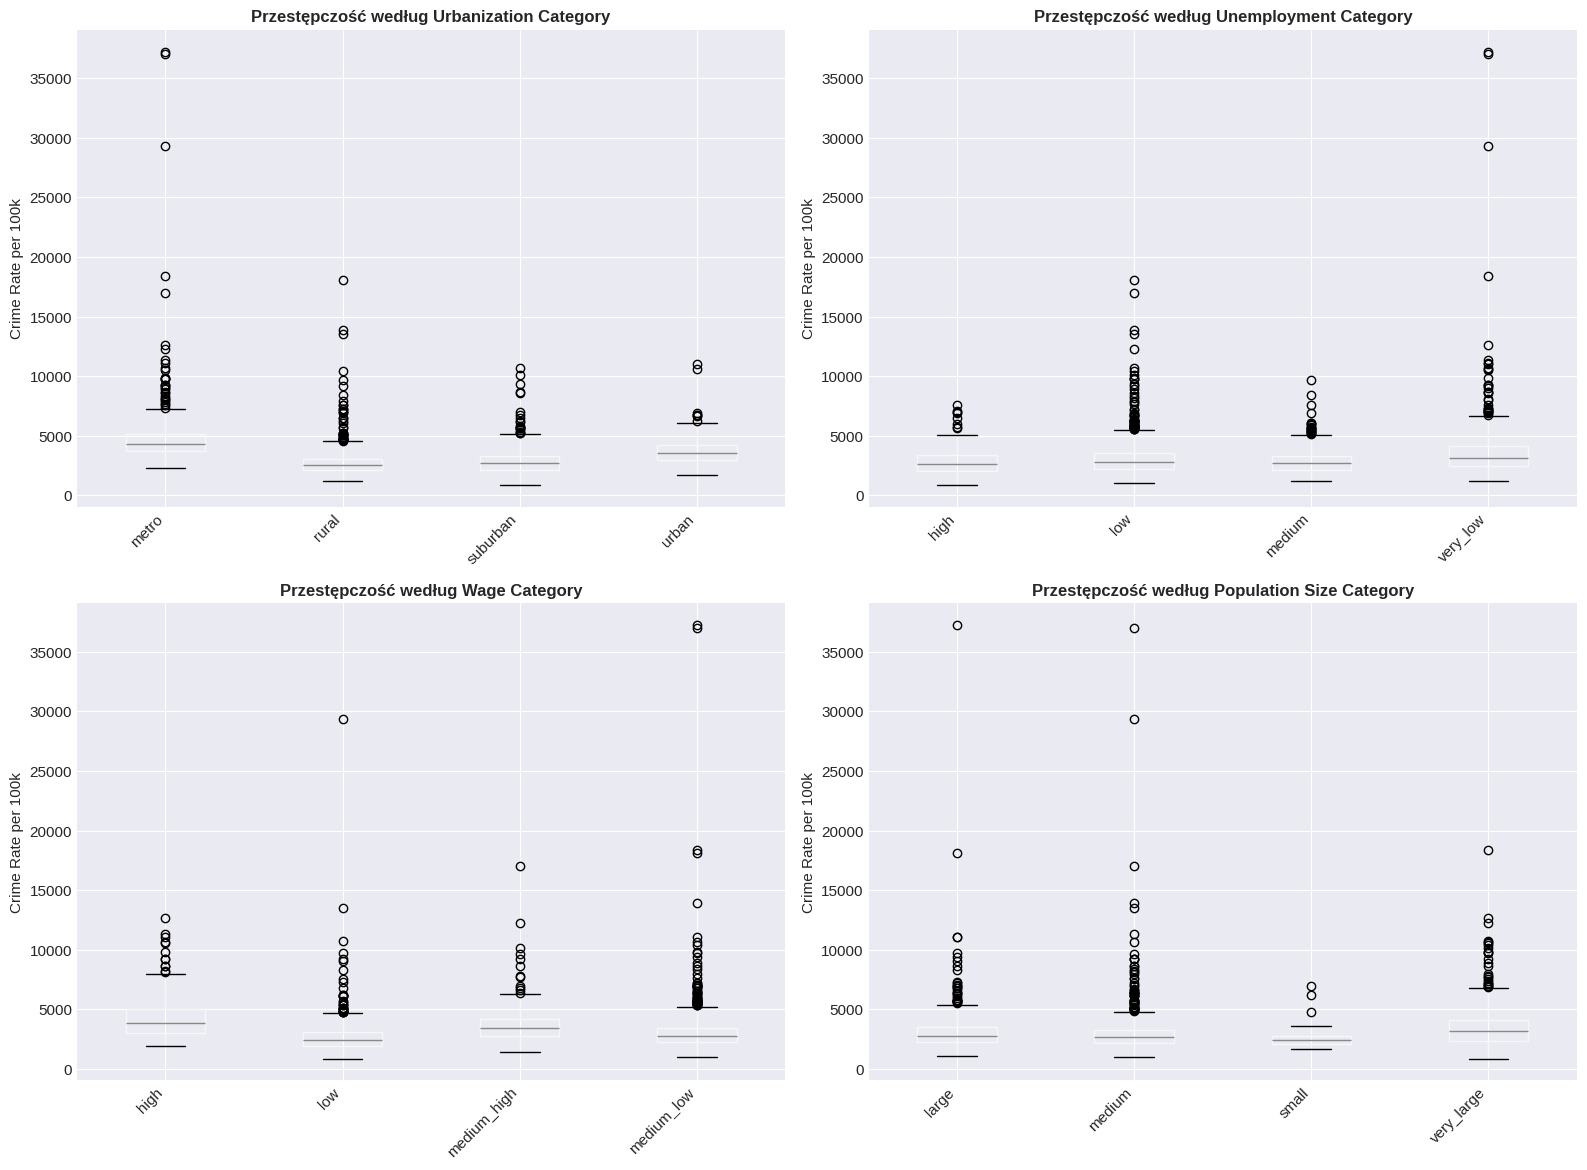


✓ Box plots zapisane jako 'korelacje_kategorie_boxplots.png'


In [22]:
print("\n" + "="*80)
print("ANALIZA PRZESTĘPCZOŚCI WEDŁUG KATEGORII")
print("="*80)

# Jeśli mamy kategorie w datasecie
categorical_vars = ['urbanization_category', 'unemployment_category', 
                    'wage_category', 'population_size_category']

existing_cats = [cat for cat in categorical_vars if cat in df_ml_ready.columns]

if existing_cats:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, cat_var in enumerate(existing_cats[:4]):
        ax = axes[idx]
        
        # Box plot
        df_sorted = df_ml_ready.sort_values(cat_var)
        df_sorted.boxplot(column='crime_rate_per_100k', by=cat_var, ax=ax)
        
        ax.set_title(f'Przestępczość według {cat_var.replace("_", " ").title()}', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('Crime Rate per 100k', fontsize=11)
        plt.sca(ax)
        plt.xticks(rotation=45, ha='right')
        
        # Statystyki
        stats_by_cat = df_ml_ready.groupby(cat_var)['crime_rate_per_100k'].agg(['mean', 'median', 'count'])
        print(f"\n--- Statystyki: {cat_var} ---")
        print(stats_by_cat.round(1))
    
    plt.suptitle('')  # Usuń domyślny tytuł
    plt.tight_layout()
    plt.savefig('./output/imgs/korelacje_kategorie_boxplots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Box plots zapisane jako 'korelacje_kategorie_boxplots.png'")

In [23]:
print("\n" + "="*80)
print("RANKING NAJSILNIEJSZYCH PREDYKTORÓW PRZESTĘPCZOŚCI")
print("="*80)

# Ranking według absolutnej wartości korelacji
predictor_ranking = abs_correlations[1:].sort_values(ascending=False)

print("\n🏆 TOP predyktory (według |r|):\n")
for rank, (feature, corr_abs) in enumerate(predictor_ranking.items(), 1):
    corr_actual = correlations_with_target[feature]
    direction = "↑ dodatnia" if corr_actual > 0 else "↓ ujemna"
    
    # Ocena siły
    if corr_abs > 0.4:
        strength = "BARDZO SILNA"
    elif corr_abs > 0.3:
        strength = "SILNA"
    elif corr_abs > 0.2:
        strength = "ŚREDNIA"
    elif corr_abs > 0.1:
        strength = "SŁABA"
    else:
        strength = "BARDZO SŁABA"
    
    print(f"{rank}. {feature:30s} | r={corr_actual:+.3f} | {direction:15s} | {strength}")

# =============================================================================
# 10. PODSUMOWANIE KLUCZOWYCH WNIOSKÓW
# =============================================================================

print("\n" + "="*80)
print("KLUCZOWE WNIOSKI Z ANALIZY KORELACJI")
print("="*80)

print("\n📌 NAJWAŻNIEJSZE ODKRYCIA:\n")

# Top 3 korelacje
top3 = predictor_ranking.head(3)
print("1. NAJSILNIEJSZE KORELACJE:")
for feature in top3.index:
    corr = correlations_with_target[feature]
    print(f"   • {feature}: r={corr:+.3f}")

print("\n2. PARADOKSY I NIEINTUICYJNE ZALEŻNOŚCI:")
print("   • Bezrobocie: ujemna korelacja (prawdopodobnie efekt urbanizacji)")
print("   • Gender ratio: ujemna korelacja (więcej kobiet w miastach)")
print("   • Youth ratio: ujemna korelacja (młodzież migruje?)")

print("\n3. URBANIZACJA JAKO KLUCZOWY CZYNNIK:")
print("   • Gęstość zaludnienia ma najsilniejszą korelację")
print("   • Miasta: wysokie zarobki + niska stopa bezrobocia + wysoka przestępczość")
print("   • Wieś: niskie zarobki + wysokie bezrobocie + niska przestępczość")

print("\n4. UWAGA - KORELACJA ≠ PRZYCZYNOWOŚĆ:")
print("   • Wszystkie zależności są KORELACYJNE, nie KAUZALNE")
print("   • Występują efekty confounding (np. urbanizacja)")
print("   • Potrzebne modele wieloczynnikowe do wyjaśnienia zależności")

print("\n" + "="*80)
print("CZĘŚĆ 2 ZAKOŃCZONA - Analiza korelacji")
print("="*80)


RANKING NAJSILNIEJSZYCH PREDYKTORÓW PRZESTĘPCZOŚCI

🏆 TOP predyktory (według |r|):

1. gender_ratio                   | r=-0.424 | ↓ ujemna        | BARDZO SILNA
2. population_density             | r=+0.420 | ↑ dodatnia      | BARDZO SILNA
3. youth_ratio                    | r=-0.290 | ↓ ujemna        | ŚREDNIA
4. wage_index                     | r=+0.270 | ↑ dodatnia      | ŚREDNIA
5. elderly_ratio                  | r=+0.200 | ↑ dodatnia      | SŁABA
6. middle_age_ratio               | r=+0.175 | ↑ dodatnia      | SŁABA
7. unemployment_rate              | r=-0.154 | ↓ ujemna        | SŁABA
8. total_population               | r=+0.151 | ↑ dodatnia      | SŁABA
9. population_change_pct          | r=-0.075 | ↓ ujemna        | BARDZO SŁABA

KLUCZOWE WNIOSKI Z ANALIZY KORELACJI

📌 NAJWAŻNIEJSZE ODKRYCIA:

1. NAJSILNIEJSZE KORELACJE:
   • gender_ratio: r=-0.424
   • population_density: r=+0.420
   • youth_ratio: r=-0.290

2. PARADOKSY I NIEINTUICYJNE ZALEŻNOŚCI:
   • Bezrobocie: ujemna ko

In [24]:
print("="*80)
print("REGRESJA WIELOKROTNA - ANALIZA WPŁYWU WIELU CZYNNIKÓW JEDNOCZEŚNIE")
print("="*80)

features = [
    "population_density",
    "unemployment_rate",
    "wage_index",
    "youth_ratio",
    "gender_ratio"
]

X = df_ml_ready[features]
y = df_ml_ready["crime_rate_per_100k"]

# Standaryzacja cech
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = sm.add_constant(X_scaled)

model = sm.OLS(y, X_scaled).fit()

REGRESJA WIELOKROTNA - ANALIZA WPŁYWU WIELU CZYNNIKÓW JEDNOCZEŚNIE


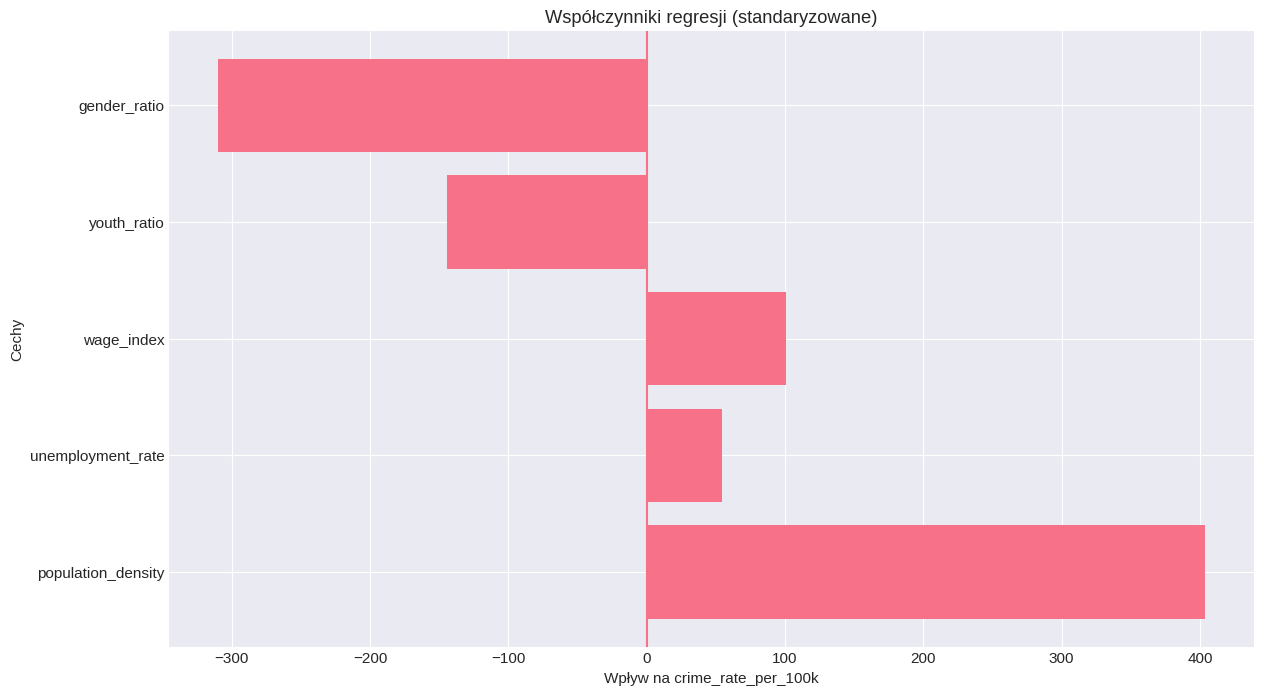

In [25]:
coef_df = pd.DataFrame({
    "feature": ["const"] + features,
    "coefficient": model.params
})

coef_df = coef_df[coef_df["feature"] != "const"]

plt.figure()
plt.barh(coef_df["feature"], coef_df["coefficient"])
plt.axvline(0)
plt.title("Współczynniki regresji (standaryzowane)")
plt.xlabel("Wpływ na crime_rate_per_100k")
plt.ylabel("Cechy")
plt.show()

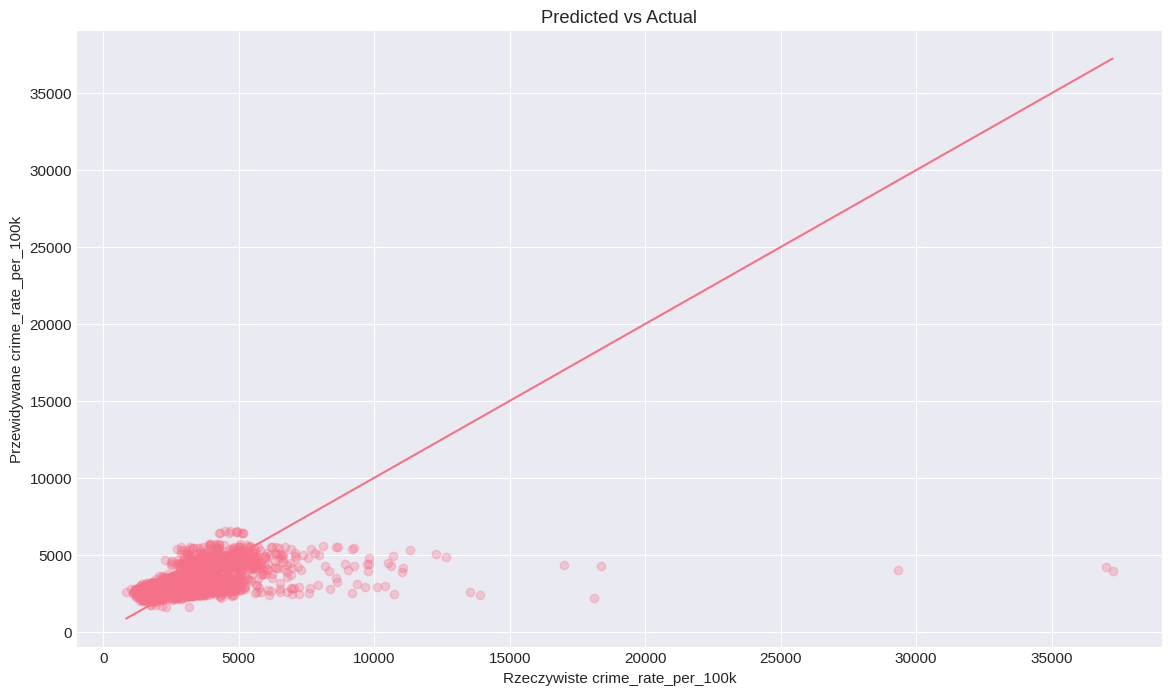

In [26]:
y_pred = model.predict(X_scaled)

plt.figure()
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.xlabel("Rzeczywiste crime_rate_per_100k")
plt.ylabel("Przewidywane crime_rate_per_100k")
plt.title("Predicted vs Actual")
plt.show()

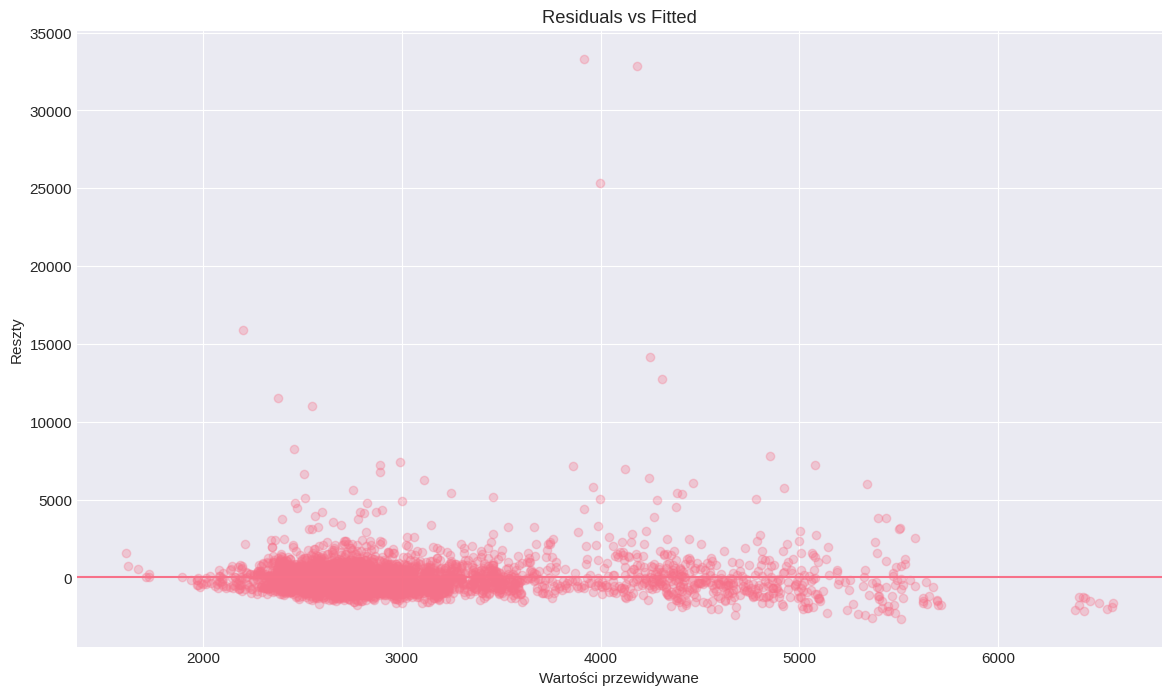

In [27]:
residuals = y - y_pred

plt.figure()
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0)
plt.xlabel("Wartości przewidywane")
plt.ylabel("Reszty")
plt.title("Residuals vs Fitted")
plt.show()

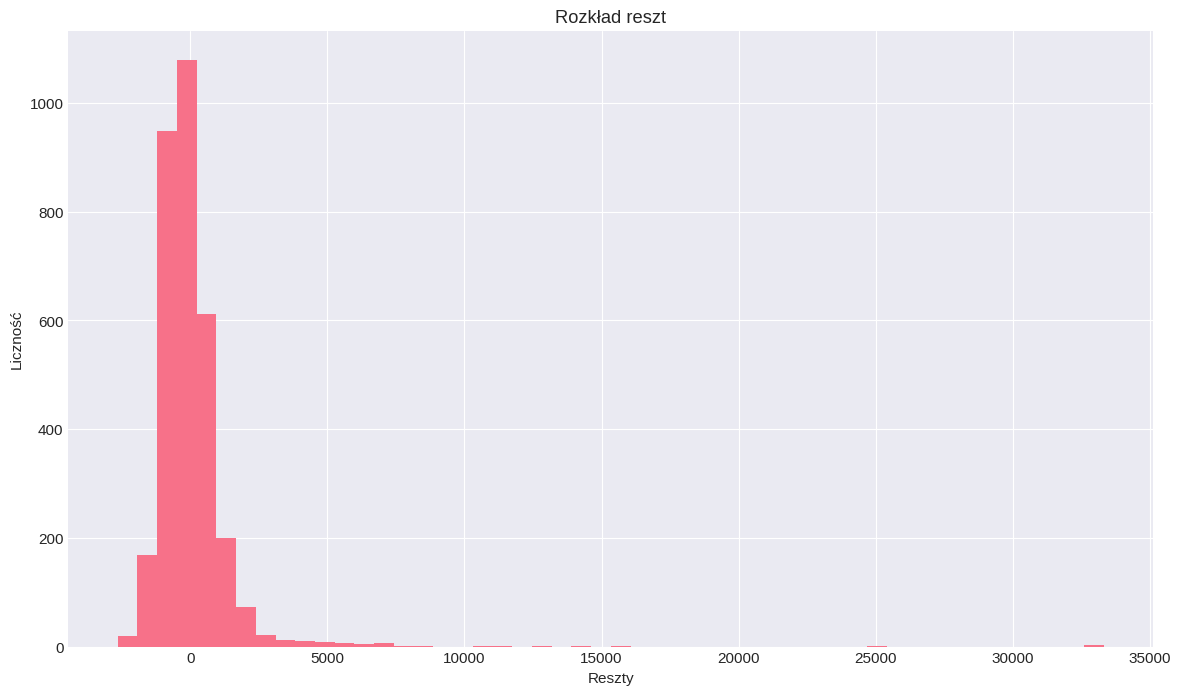

In [28]:
plt.figure()
plt.hist(residuals, bins=50)
plt.title("Rozkład reszt")
plt.xlabel("Reszty")
plt.ylabel("Liczność")
plt.show()


In [29]:
print("\n" + "="*80)
print("DIAGNOSTYKA MODELU - ANALIZA RESIDUALS")
print("="*80)

# Obliczenie residuals
residuals = model_full.resid
fitted_values = model_full.fittedvalues

# Statystyki residuals
print("\n--- Statystyki residuals ---")
print(f"Średnia: {residuals.mean():.6f} (powinno być ~0)")
print(f"Odch. std: {residuals.std():.2f}")
print(f"Skewness: {stats.skew(residuals):.3f} (symetryczny rozkład ~0)")
print(f"Kurtosis: {stats.kurtosis(residuals):.3f} (normalny rozkład ~0)")

# Test normalności residuals - Jarque-Bera
jb_stat, jb_pvalue = stats.jarque_bera(residuals)
print(f"\nTest Jarque-Bera (normalność residuals):")
print(f"  Statystyka: {jb_stat:.2f}")
print(f"  p-value: {jb_pvalue:.4f}")
if jb_pvalue > 0.05:
    print("  ✓ Residuals mają rozkład normalny (p>0.05)")
else:
    print("  ✗ Residuals NIE mają rozkładu normalnego (p<0.05)")

# Test Durbin-Watson (autokorelacja)
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f"\nTest Durbin-Watson (autokorelacja residuals):")
print(f"  Statystyka: {dw_stat:.3f}")
print(f"  Interpretacja: 2.0 = brak autokorelacji")
if 1.5 < dw_stat < 2.5:
    print("  ✓ Brak problematycznej autokorelacji")
else:
    print("  ⚠️ Możliwa autokorelacja residuals")

# Wizualizacja diagnostyki
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Fitted
ax1 = axes[0, 0]
ax1.scatter(fitted_values, residuals, alpha=0.5, s=10)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Fitted values (przewidywane)', fontsize=11)
ax1.set_ylabel('Residuals (błędy)', fontsize=11)
ax1.set_title('Residuals vs Fitted\n(sprawdzamy liniowość)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Dodanie smooth line
from scipy.signal import savgol_filter
sorted_idx = np.argsort(fitted_values)
try:
    smooth = savgol_filter(residuals.iloc[sorted_idx], 51, 3)
    ax1.plot(fitted_values.iloc[sorted_idx], smooth, color='blue', linewidth=2, label='Trend')
    ax1.legend()
except:
    pass

# 2. Q-Q Plot (normalność residuals)
ax2 = axes[0, 1]
qq = ProbPlot(residuals)
qq.qqplot(line='45', ax=ax2)
ax2.set_title('Q-Q Plot\n(sprawdzamy normalność residuals)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Scale-Location (homoskedastyczność)
ax3 = axes[1, 0]
standardized_residuals = residuals / residuals.std()
ax3.scatter(fitted_values, np.sqrt(np.abs(standardized_residuals)), alpha=0.5, s=10)
ax3.set_xlabel('Fitted values', fontsize=11)
ax3.set_ylabel('√|Standaryzowane residuals|', fontsize=11)
ax3.set_title('Scale-Location\n(sprawdzamy homoskedastyczność)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Histogram residuals
ax4 = axes[1, 1]
ax4.hist(residuals, bins=50, edgecolor='black', alpha=0.7, density=True)
# Dodanie krzywej normalnej
mu, std = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
ax4.plot(x, stats.norm.pdf(x, mu, std), 'r-', linewidth=2, label='Rozkład normalny')
ax4.set_xlabel('Residuals', fontsize=11)
ax4.set_ylabel('Gęstość', fontsize=11)
ax4.set_title('Rozkład Residuals\n(powinien być normalny)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('regression_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Diagnostyka zapisana jako 'regression_diagnostics.png'")


DIAGNOSTYKA MODELU - ANALIZA RESIDUALS


NameError: name 'model_full' is not defined

In [ ]:
print(model_full.rsquared_adj)
print(model_full.rsquared)
print(model_reduced.rsquared_adj)
if model_reduced.rsquared_adj > model_full.rsquared_adj:
    print(f"   Model zredukowany jest lepszy (wyższy Adj. R²)")
elif model_reduced.aic < model_full.aic:
    print(f"   Model zredukowany jest lepszy (niższy AIC)")
else:
    print(f"   Model pełny jest lepszy (ale różnica minimalna)")


In [ ]:
plt.figure()
plt.hist(residuals, bins=50)
plt.title("Rozkład reszt")
plt.xlabel("Reszty")
plt.ylabel("Liczność")
plt.show()

RANDOM FOREST

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model Random Forest
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,          # Ograniczenie głębokości - zapobiega przeuczeniu
    min_samples_split=20,  # Wymaga min 20 próbek do podziału
    min_samples_leaf=10,   # Min 10 próbek w liściu
    max_features='sqrt',   # Użyj sqrt(n_features) na każdy split
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predykcja
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Metryki
print("=== WYNIKI RANDOM FOREST ===")
print(f"R² (train): {r2_score(y_train, y_pred_train):.3f}")
print(f"R² (test):  {r2_score(y_test, y_pred_test):.3f}")
print(f"RMSE (test): {np.sqrt(mean_squared_error(y_test, y_pred_test)):.0f}")
print(f"MAE (test):  {mean_absolute_error(y_test, y_pred_test):.0f}")

# Cross-validation (5-fold)
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print(f"\nCross-validation R² (mean): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== WAŻNOŚĆ CECH ===")
print(feature_importance)

# Wizualizacja Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Ważność cech w przewidywaniu wskaźnika przestępczości (Random Forest)')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.savefig('./output/imgs/feature_importance_rf.png', dpi=300, bbox_inches='tight')
plt.show()

Karta Polski według pozioma przestępczośći

MAPA POLSKI - PRZESTĘPCZOŚĆ WEDŁUG WOJEWÓDZTW (2024)
✓ Połączono dane geograficzne z danymi o przestępczości
  Województwa z danymi: 16/16


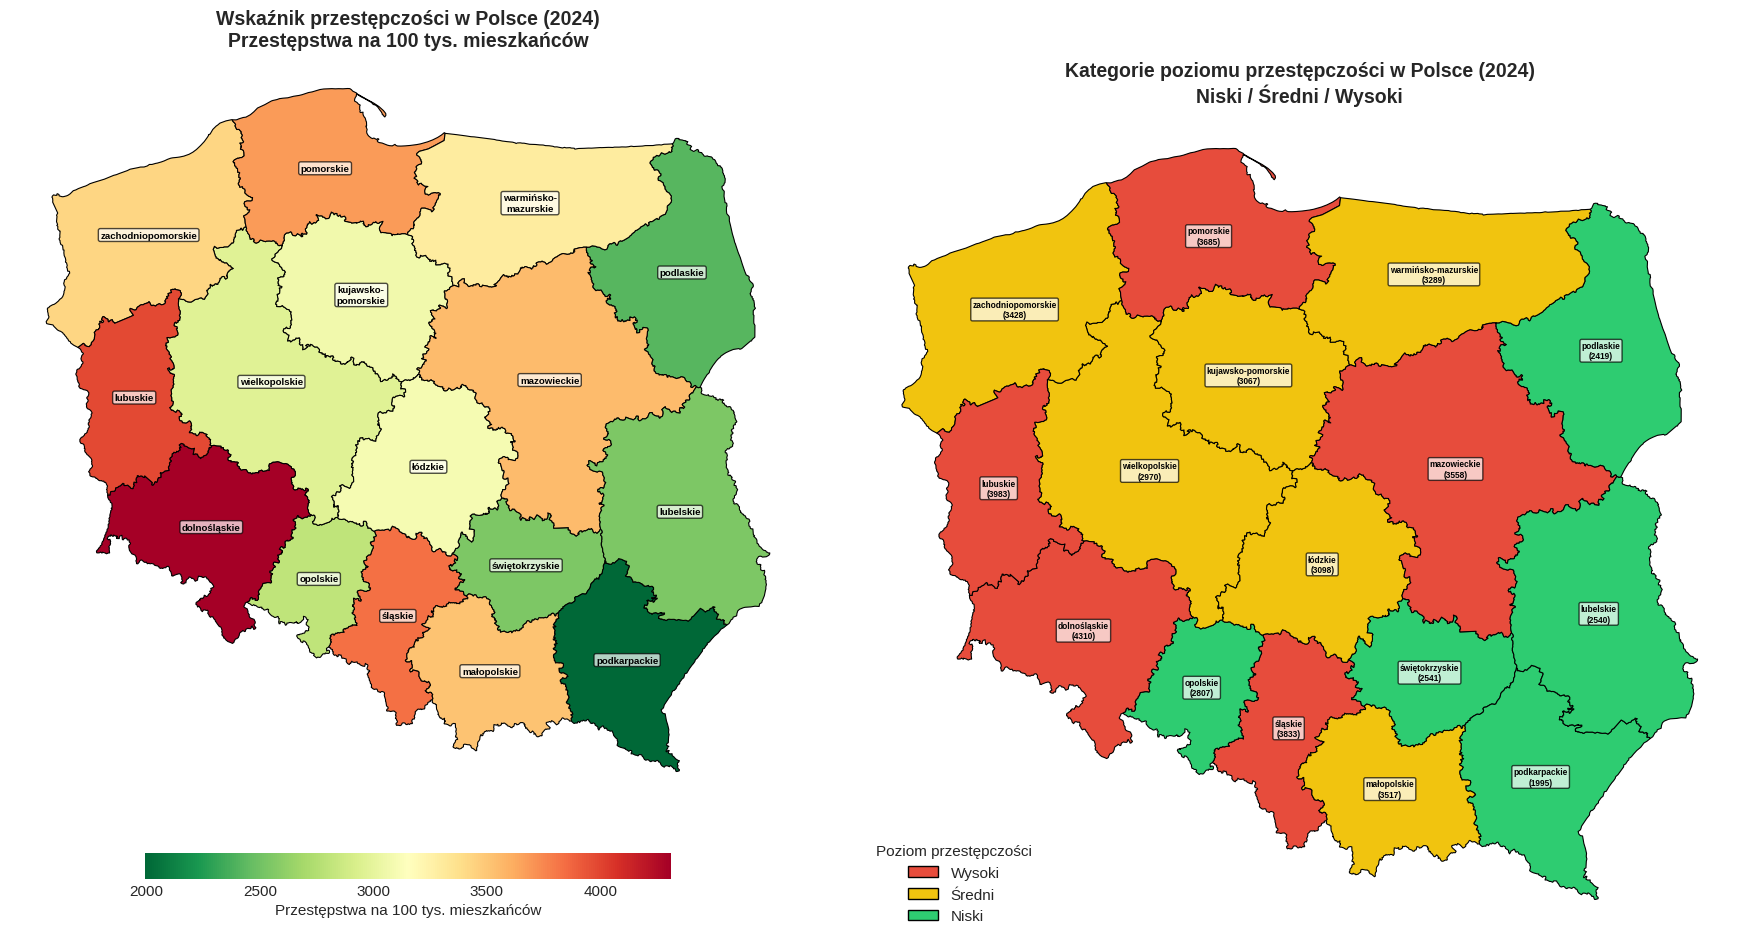


✓ Mapa zapisana jako 'mapa_przestepczosc_wojewodztwa.png'

PODSUMOWANIE - KATEGORIE PRZESTĘPCZOŚCI

Progi kategorii:
  Niski:  ≤ 2962 przestępstw na 100k
  Średni: 2962 - 3519 przestępstw na 100k
  Wysoki: > 3519 przestępstw na 100k

--- Województwa według kategorii ---

Wysoki poziom (5 woj.):
  • śląskie: 3833
  • dolnośląskie: 4310
  • pomorskie: 3685
  • mazowieckie: 3558
  • lubuskie: 3983

Średni poziom (6 woj.):
  • wielkopolskie: 2970
  • zachodniopomorskie: 3428
  • kujawsko-pomorskie: 3067
  • małopolskie: 3517
  • warmińsko-mazurskie: 3289
  • łódzkie: 3098

Niski poziom (5 woj.):
  • opolskie: 2807
  • świętokrzyskie: 2541
  • podlaskie: 2419
  • podkarpackie: 1995
  • lubelskie: 2540


In [31]:
import geopandas as gpd

print("="*80)
print("MAPA POLSKI - PRZESTĘPCZOŚĆ WEDŁUG WOJEWÓDZTW (2024)")
print("="*80)

# Wczytanie danych geograficznych
gdf = gpd.read_file('./data/geo/wojewodztwa.geojson')

# Przygotowanie danych o przestępczości na poziomie województw (2024)
# Używamy już obliczonych danych z wcześniejszej analizy
wojewodztwa_2024_map = wojewodztwa_2024.copy()
wojewodztwa_2024_map['nazwa'] = wojewodztwa_2024_map['wojewodztwo']

# Połączenie danych geograficznych z danymi o przestępczości
gdf_merged = gdf.merge(wojewodztwa_2024_map, on='nazwa', how='left')

print(f"✓ Połączono dane geograficzne z danymi o przestępczości")
print(f"  Województwa z danymi: {gdf_merged['crime_rate_per_100k'].notna().sum()}/16")

# Tworzenie mapy
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Mapa 1: Choropleth - poziom przestępczości
ax1 = axes[0]
gdf_merged.plot(
    column='crime_rate_per_100k',
    cmap='RdYlGn_r',  # Czerwony = wysoka przestępczość, Zielony = niska
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    legend_kwds={
        'label': 'Przestępstwa na 100 tys. mieszkańców',
        'orientation': 'horizontal',
        'shrink': 0.6,
        'pad': 0.05
    },
    ax=ax1
)

# Dodanie nazw województw na mapie
for idx, row in gdf_merged.iterrows():
    centroid = row.geometry.centroid
    ax1.annotate(
        row['nazwa'].replace('-', '-\n'),
        xy=(centroid.x, centroid.y),
        ha='center', va='center',
        fontsize=7,
        fontweight='bold',
        color='black',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7)
    )

ax1.set_title('Wskaźnik przestępczości w Polsce (2024)\nPrzestępstwa na 100 tys. mieszkańców', 
              fontsize=14, fontweight='bold')
ax1.axis('off')

# Mapa 2: Kategorie przestępczości (niski/średni/wysoki)
ax2 = axes[1]

# Podział na kategorie
crime_median = gdf_merged['crime_rate_per_100k'].median()
crime_q1 = gdf_merged['crime_rate_per_100k'].quantile(0.33)
crime_q3 = gdf_merged['crime_rate_per_100k'].quantile(0.67)

def categorize_crime(rate):
    if pd.isna(rate):
        return 'Brak danych'
    elif rate <= crime_q1:
        return 'Niski'
    elif rate <= crime_q3:
        return 'Średni'
    else:
        return 'Wysoki'

gdf_merged['crime_category'] = gdf_merged['crime_rate_per_100k'].apply(categorize_crime)

# Колоры для категорий - явный маппинг
category_colors = {'Niski': '#2ecc71', 'Średni': '#f1c40f', 'Wysoki': '#e74c3c', 'Brak danych': '#bdc3c7'}

# Применяем цвета к каждому региону
gdf_merged['color'] = gdf_merged['crime_category'].map(category_colors)

gdf_merged.plot(
    color=gdf_merged['color'],
    linewidth=0.8,
    edgecolor='black',
    ax=ax2
)

# Создаём легенду вручную
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', edgecolor='black', label='Wysoki'),
    Patch(facecolor='#f1c40f', edgecolor='black', label='Średni'),
    Patch(facecolor='#2ecc71', edgecolor='black', label='Niski')
]
ax2.legend(handles=legend_elements, loc='lower left', title='Poziom przestępczości')

# Dodanie nazw i wartości na mapie
for idx, row in gdf_merged.iterrows():
    centroid = row.geometry.centroid
    label = f"{row['nazwa']}\n({row['crime_rate_per_100k']:.0f})" if pd.notna(row['crime_rate_per_100k']) else row['nazwa']
    ax2.annotate(
        label,
        xy=(centroid.x, centroid.y),
        ha='center', va='center',
        fontsize=6,
        fontweight='bold',
        color='black',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7)
    )

ax2.set_title('Kategorie poziomu przestępczości w Polsce (2024)\nNiski / Średni / Wysoki', 
              fontsize=14, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.savefig('./output/imgs/mapa_przestepczosc_wojewodztwa.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Mapa zapisana jako 'mapa_przestepczosc_wojewodztwa.png'")

# Podsumowanie statystyk
print("\n" + "="*80)
print("PODSUMOWANIE - KATEGORIE PRZESTĘPCZOŚCI")
print("="*80)
print(f"\nProgi kategorii:")
print(f"  Niski:  ≤ {crime_q1:.0f} przestępstw na 100k")
print(f"  Średni: {crime_q1:.0f} - {crime_q3:.0f} przestępstw na 100k")
print(f"  Wysoki: > {crime_q3:.0f} przestępstw na 100k")

print("\n--- Województwa według kategorii ---")
for cat in ['Wysoki', 'Średni', 'Niski']:
    woj_list = gdf_merged[gdf_merged['crime_category'] == cat]['nazwa'].tolist()
    print(f"\n{cat} poziom ({len(woj_list)} woj.):")
    for woj in woj_list:
        rate = gdf_merged[gdf_merged['nazwa'] == woj]['crime_rate_per_100k'].values[0]
        print(f"  • {woj}: {rate:.0f}")